logs/best_epoch_weights.pth model, and classes loaded.
Configurations:
----------------------------------------------------------------------
|                     keys |                                   values|
----------------------------------------------------------------------
|               model_path |              logs/best_epoch_weights.pth|
|              num_classes |                                        2|
|                 backbone |                                mobilenet|
|              input_shape |                               [512, 512]|
|        downsample_factor |                                       16|
|                 mix_type |                                        0|
|                     cuda |                                    False|
----------------------------------------------------------------------


Input image filename: 20.jpg


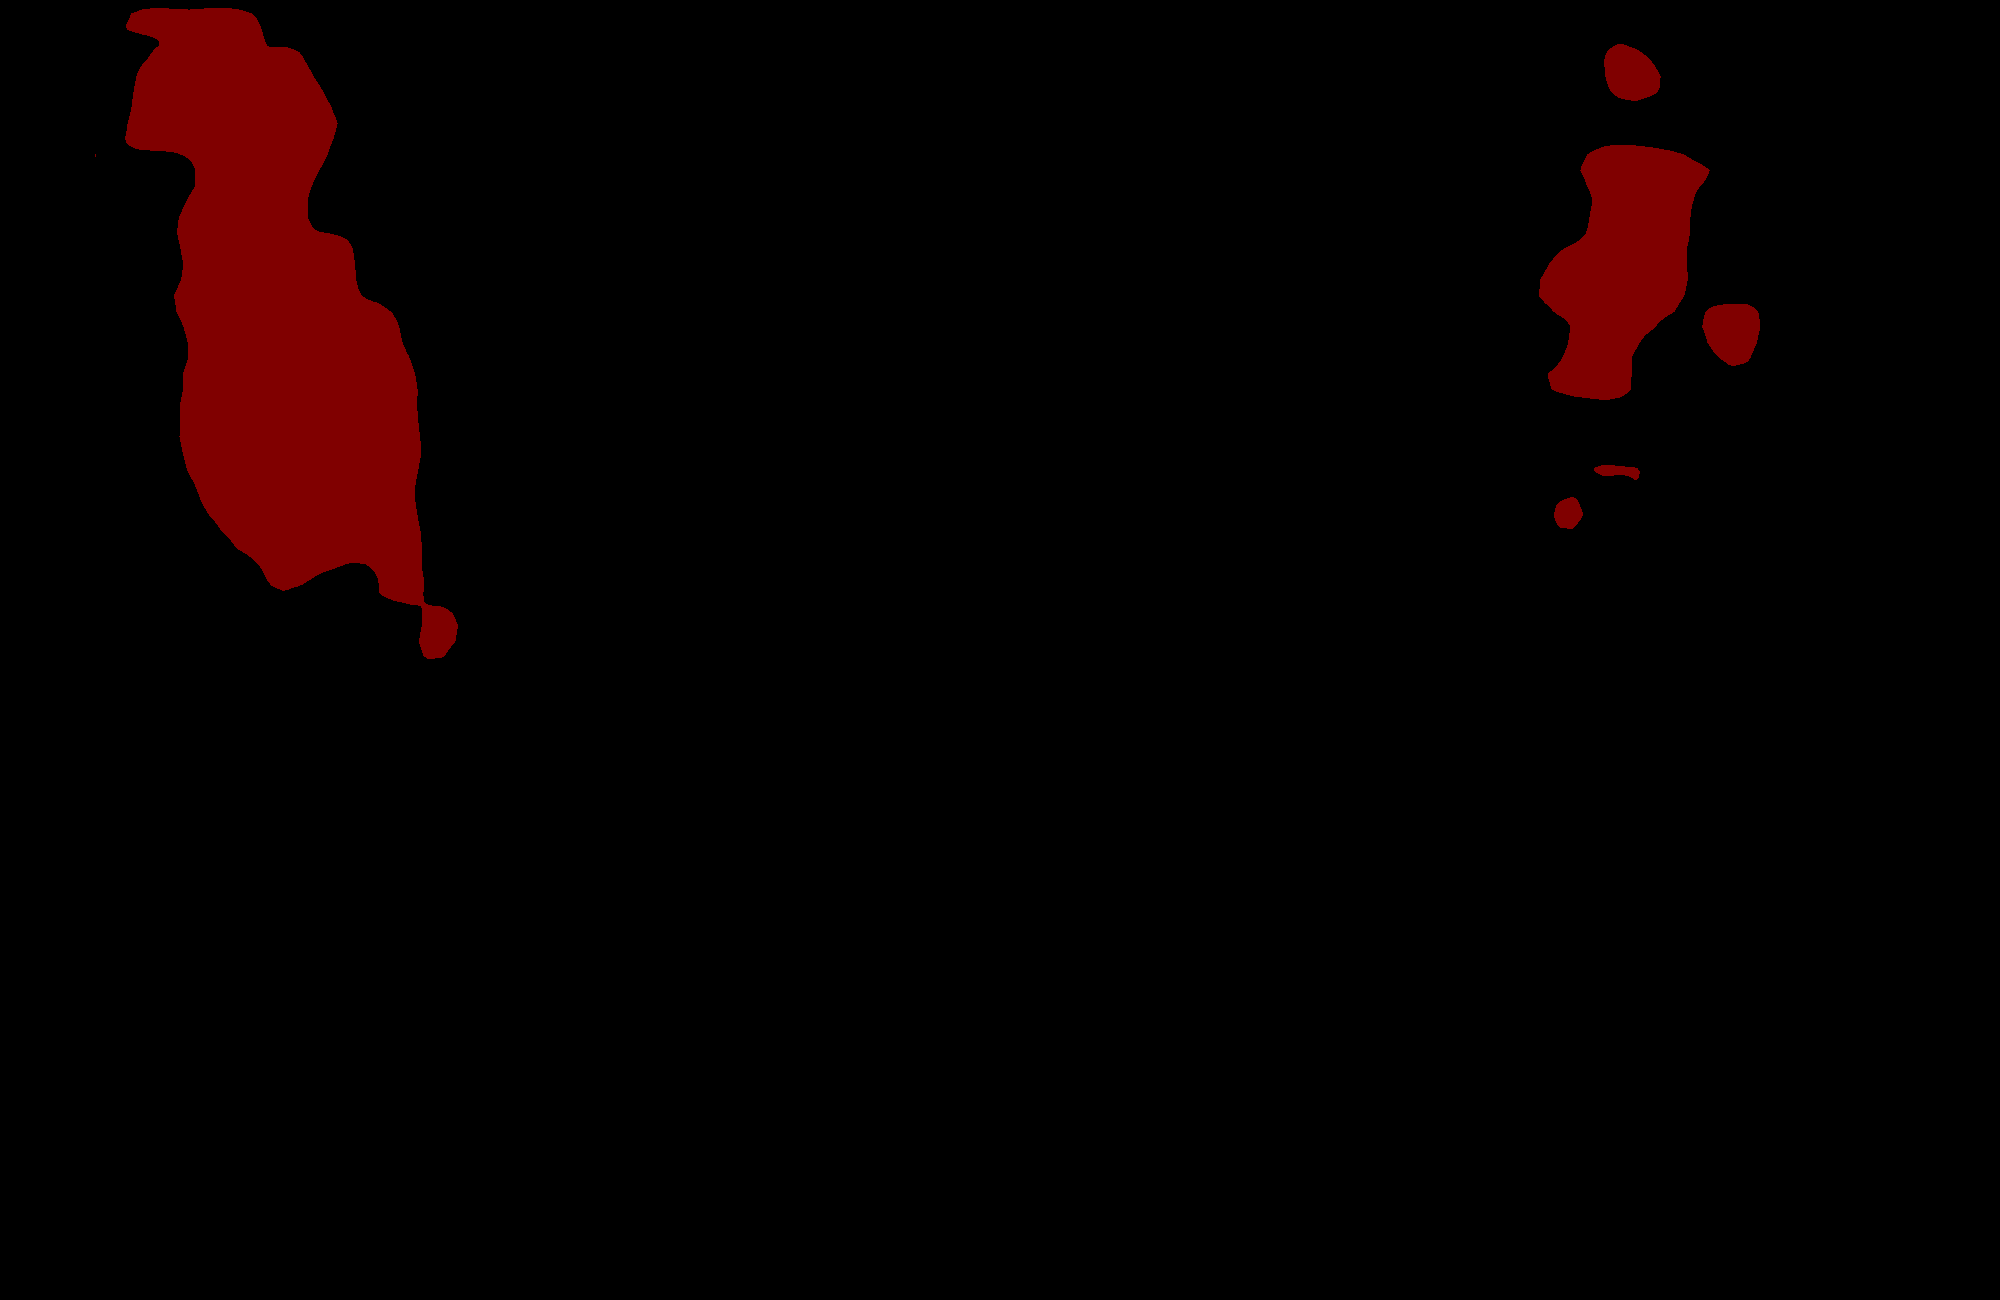

Input image filename: 4.jpg


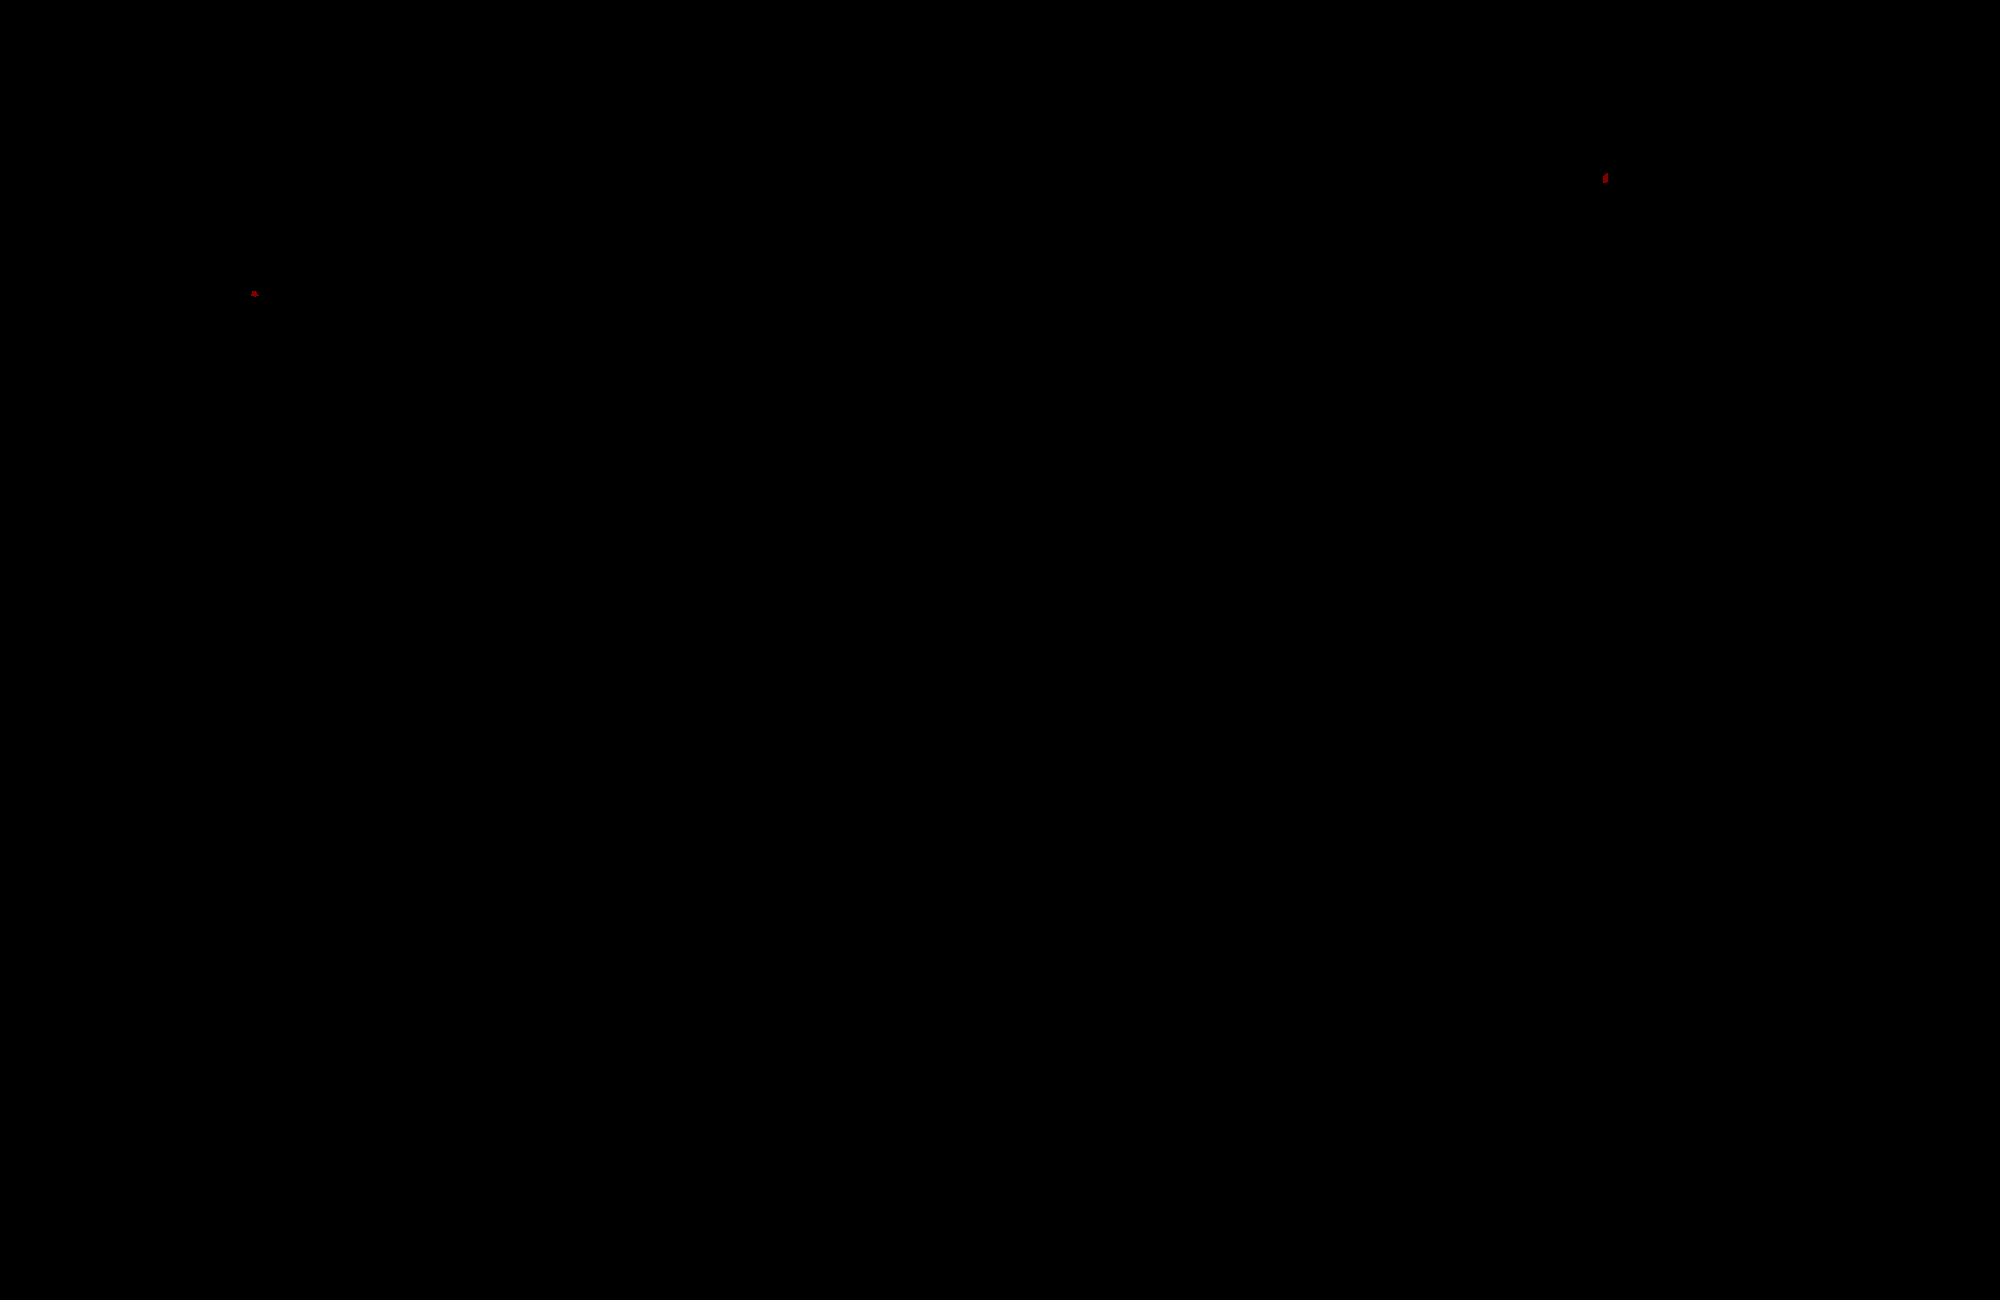

In [ ]:
#----------------------------------------------------#
#   将单张图片预测、摄像头检测和FPS测试功能
#   整合到了一个py文件中，通过指定mode进行模式的修改。
#----------------------------------------------------#
import time

import cv2
import numpy as np
from PIL import Image

from deeplab import DeeplabV3

if __name__ == "__main__":
    #-------------------------------------------------------------------------#
    #   如果想要修改对应种类的颜色，到__init__函数里修改self.colors即可
    #-------------------------------------------------------------------------#
    deeplab = DeeplabV3()
    #----------------------------------------------------------------------------------------------------------#
    #   mode用于指定测试的模式：
    #   'predict'           表示单张图片预测，如果想对预测过程进行修改，如保存图片，截取对象等，可以先看下方详细的注释
    #   'video'             表示视频检测，可调用摄像头或者视频进行检测，详情查看下方注释。
    #   'fps'               表示测试fps，使用的图片是img里面的street.jpg，详情查看下方注释。
    #   'dir_predict'       表示遍历文件夹进行检测并保存。默认遍历img文件夹，保存img_out文件夹，详情查看下方注释。
    #   'export_onnx'       表示将模型导出为onnx，需要pytorch1.7.1以上。
    #----------------------------------------------------------------------------------------------------------#
    mode = "predict"
    #-------------------------------------------------------------------------#
    #   count               指定了是否进行目标的像素点计数（即面积）与比例计算
    #   name_classes        区分的种类，和json_to_dataset里面的一样，用于打印种类和数量
    #
    #   count、name_classes仅在mode='predict'时有效
    #-------------------------------------------------------------------------#
    count           = False
    name_classes    = ["background","0"]
    # name_classes    = ["background","cat","dog"]
    #----------------------------------------------------------------------------------------------------------#
    #   video_path          用于指定视频的路径，当video_path=0时表示检测摄像头
    #                       想要检测视频，则设置如video_path = "xxx.mp4"即可，代表读取出根目录下的xxx.mp4文件。
    #   video_save_path     表示视频保存的路径，当video_save_path=""时表示不保存
    #                       想要保存视频，则设置如video_save_path = "yyy.mp4"即可，代表保存为根目录下的yyy.mp4文件。
    #   video_fps           用于保存的视频的fps
    #
    #   video_path、video_save_path和video_fps仅在mode='video'时有效
    #   保存视频时需要ctrl+c退出或者运行到最后一帧才会完成完整的保存步骤。
    #----------------------------------------------------------------------------------------------------------#
    video_path      = 0
    video_save_path = ""
    video_fps       = 25.0
    #----------------------------------------------------------------------------------------------------------#
    #   test_interval       用于指定测量fps的时候，图片检测的次数。理论上test_interval越大，fps越准确。
    #   fps_image_path      用于指定测试的fps图片
    #   
    #   test_interval和fps_image_path仅在mode='fps'有效
    #----------------------------------------------------------------------------------------------------------#
    test_interval = 100
    fps_image_path  = "img/street.jpg"
    #-------------------------------------------------------------------------#
    #   dir_origin_path     指定了用于检测的图片的文件夹路径
    #   dir_save_path       指定了检测完图片的保存路径
    #   
    #   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
    #-------------------------------------------------------------------------#
    dir_origin_path = "img/"
    dir_save_path   = "img_out/"
    #-------------------------------------------------------------------------#
    #   simplify            使用Simplify onnx
    #   onnx_save_path      指定了onnx的保存路径
    #-------------------------------------------------------------------------#
    simplify        = True
    onnx_save_path  = "model_data/models.onnx"

    if mode == "predict":
        '''
        predict.py有几个注意点
        1、该代码无法直接进行批量预测，如果想要批量预测，可以利用os.listdir()遍历文件夹，利用Image.open打开图片文件进行预测。
        具体流程可以参考get_miou_prediction.py，在get_miou_prediction.py即实现了遍历。
        2、如果想要保存，利用r_image.save("img.jpg")即可保存。
        3、如果想要原图和分割图不混合，可以把blend参数设置成False。
        4、如果想根据mask获取对应的区域，可以参考detect_image函数中，利用预测结果绘图的部分，判断每一个像素点的种类，然后根据种类获取对应的部分。
        seg_img = np.zeros((np.shape(pr)[0],np.shape(pr)[1],3))
        for c in range(self.num_classes):
            seg_img[:, :, 0] += ((pr == c)*( self.colors[c][0] )).astype('uint8')
            seg_img[:, :, 1] += ((pr == c)*( self.colors[c][1] )).astype('uint8')
            seg_img[:, :, 2] += ((pr == c)*( self.colors[c][2] )).astype('uint8')
        '''
        while True:
            img = input('Input image filename:')
            try:
                image = Image.open(img)
            except:
                print('Open Error! Try again!')
                continue
            else:
                r_image = deeplab.detect_image(image, count=count, name_classes=name_classes)
                r_image.show()

    elif mode == "video":
        capture=cv2.VideoCapture(video_path)
        if video_save_path!="":
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

        ref, frame = capture.read()
        if not ref:
            raise ValueError("未能正确读取摄像头（视频），请注意是否正确安装摄像头（是否正确填写视频路径）。")

        fps = 0.0
        while(True):
            t1 = time.time()
            # 读取某一帧
            ref, frame = capture.read()
            if not ref:
                break
            # 格式转变，BGRtoRGB
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            # 转变成Image
            frame = Image.fromarray(np.uint8(frame))
            # 进行检测
            frame = np.array(deeplab.detect_image(frame))
            # RGBtoBGR满足opencv显示格式
            frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
            
            fps  = ( fps + (1./(time.time()-t1)) ) / 2
            print("fps= %.2f"%(fps))
            frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("video",frame)
            c= cv2.waitKey(1) & 0xff 
            if video_save_path!="":
                out.write(frame)

            if c==27:
                capture.release()
                break
        print("Video Detection Done!")
        capture.release()
        if video_save_path!="":
            print("Save processed video to the path :" + video_save_path)
            out.release()
        cv2.destroyAllWindows()

    elif mode == "fps":
        img = Image.open(fps_image_path)
        tact_time = deeplab.get_FPS(img, test_interval)
        print(str(tact_time) + ' seconds, ' + str(1/tact_time) + 'FPS, @batch_size 1')
        
    elif mode == "dir_predict":
        import os
        from tqdm import tqdm

        img_names = os.listdir(dir_origin_path)
        for img_name in tqdm(img_names):
            if img_name.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff')):
                image_path  = os.path.join(dir_origin_path, img_name)
                image       = Image.open(image_path)
                r_image     = deeplab.detect_image(image)
                if not os.path.exists(dir_save_path):
                    os.makedirs(dir_save_path)
                r_image.save(os.path.join(dir_save_path, img_name))
    elif mode == "export_onnx":
        deeplab.convert_to_onnx(simplify, onnx_save_path)
        
    else:
        raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps' or 'dir_predict'.")
 # VOCdevkit/VOC2007/JPEGImages/278.jpg